# 7 October 2021

## **Latihan Ensemble Model Boosting**

### **Gunakan dataset churn**


**Can you develop a machine learning model that can predict the customers who will leave the company?**

- The aim is to estimate whether a bank's customers leave the bank (churn) or not.

**Dataset overview:**
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.

**Features:**
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany/ France/ Spain)
- Gender: Gender (Female/ Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: The number of bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Churn or not? (0 = No, 1 = Yes)

**Instructions:**
- Lakukan eksplorasi data. Apa saja insight yang kamu dapat?
- Lakukan data cleaning dan preprocessing yang kamu anggap dibutuhkan untuk dataset ini.
- Tentukan metric yang sesuai dengan case dataset ini. Jelaskan alasan mengapa memilih metric tersebut.
- Lakukan modeling dengan menggunakan model decision tree, random forest, adaboost, gradientboost, xgboost.
- Pilih 2 model terbaik dan lakukan hyperparameter tuning.
- Bandingkan hasil sebelum dan sesudah tuning. Model mana yang performanya paling optimal?

## **Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, confusion_matrix, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

## **Load & explore dataset**

In [2]:
df = pd.read_csv('churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
print(df['Exited'].value_counts())
print()
print(df['Exited'].value_counts()/len(df['Exited'])*100)

0    7963
1    2037
Name: Exited, dtype: int64

0    79.63
1    20.37
Name: Exited, dtype: float64


In [5]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['Surname', 'Geography', 'Gender']

In [6]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in Surname:  2932
Unique values:  ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Total unique values in Geography:  3
Unique values:  ['France' 'Spain' 'Germany']

Total unique values in Gender:  2
Unique values:  ['Female' 'Male']



In [7]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Exited']))]
num_features

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [8]:
df.corr()['Exited']

RowNumber         -0.016571
CustomerId        -0.006248
CreditScore       -0.027094
Age                0.285323
Tenure            -0.014001
Balance            0.118533
NumOfProducts     -0.047820
HasCrCard         -0.007138
IsActiveMember    -0.156128
EstimatedSalary    0.012097
Exited             1.000000
Name: Exited, dtype: float64

In [9]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [10]:
df.groupby('Geography').sum()['Exited']

Geography
France     810
Germany    814
Spain      413
Name: Exited, dtype: int64

In [11]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## **EDA**

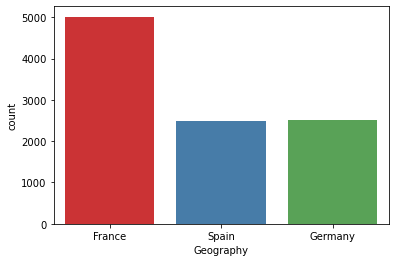

In [12]:
sns.set_palette('Set1')

sns.countplot(x='Geography', data=df);

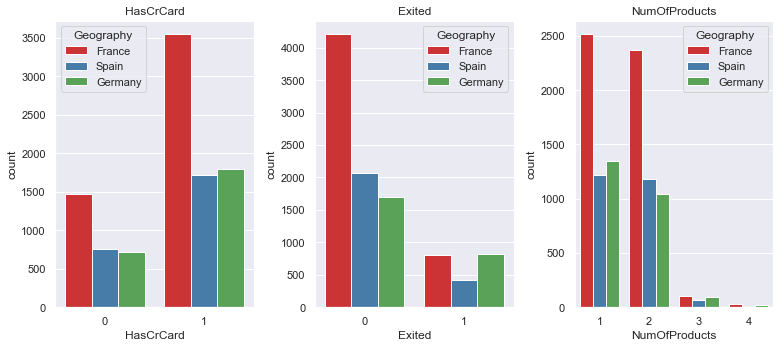

In [13]:
features = ['HasCrCard', 'Exited', 'NumOfProducts']
plt.figure(figsize=(11, 5))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(1, 3, plotnumber)
    sns.countplot(x=feature, hue='Geography', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

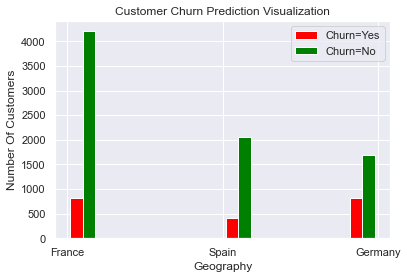

In [14]:
geo_churn_no = df[df.Exited==0]['Geography']
geo_churn_yes = df[df.Exited==1]['Geography']

plt.xlabel('Geography')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([geo_churn_yes, geo_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

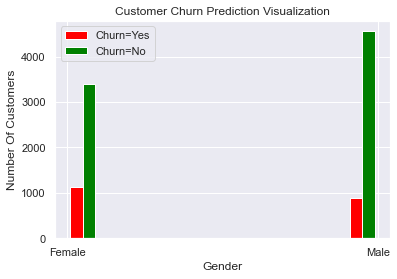

In [15]:
gender_churn_no = df[df.Exited==0]['Gender']
gender_churn_yes = df[df.Exited==1]['Gender']

plt.xlabel('Gender')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([gender_churn_yes, gender_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

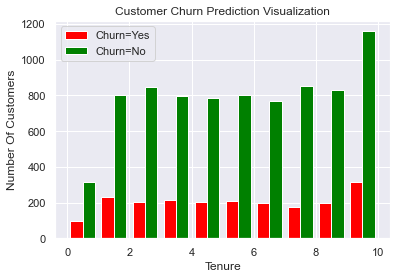

In [16]:
tenure_churn_no = df[df.Exited==0].Tenure
tenure_churn_yes = df[df.Exited==1].Tenure

plt.xlabel('Tenure')
plt.ylabel('Number Of Customers')
plt.title('Customer Churn Prediction Visualization')
plt.hist([tenure_churn_yes, tenure_churn_no], color=['red', 'green'], label=['Churn=Yes', 'Churn=No'])
plt.legend();

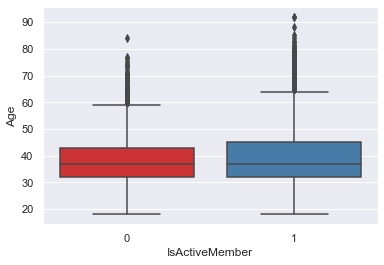

In [17]:
sns.boxplot(x='IsActiveMember', y='Age', data=df);

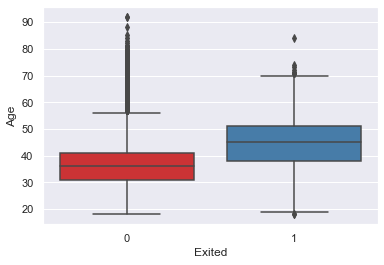

In [18]:
sns.boxplot(x='Exited', y='Age', data=df);

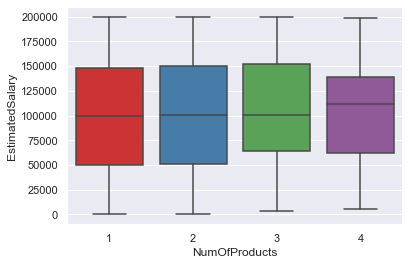

In [19]:
sns.boxplot(x='NumOfProducts', y='EstimatedSalary', data=df);

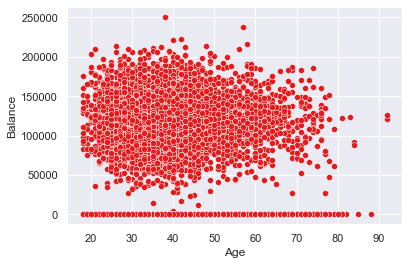

In [20]:
sns.scatterplot(x='Age', y='Balance', data=df);

## **Drop unnecessary features**

In [21]:
# Drop some columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## **Data splitting**

In [22]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [23]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=0
)

## **Data preprocessing**

In [24]:
# Transformer scheme
onehot = OneHotEncoder(drop='first')

transformer = ColumnTransformer([
    ('onehot', onehot, ['Geography', 'Gender'])
], remainder='passthrough')

In [25]:
# Fit and transform transformer
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

In [26]:
# Scaling
scaler = MinMaxScaler()

X_train_prep_scaled = scaler.fit_transform(X_train_prep)
X_test_prep_scaled = scaler.transform(X_test_prep)

## **Model benchmark**

In [27]:
# DecsionTree
tree = DecisionTreeClassifier(random_state=0)

# RandomForest
rf = RandomForestClassifier(random_state=0)

# Adaboost
ada = AdaBoostClassifier(tree, random_state=0)

# Gradientboost
gbc = GradientBoostingClassifier(random_state=0)

# ExtremeGradientBosst
xgbc = XGBClassifier(random_state=0, verbosity=0)

In [28]:
# Define imbalanced treatment method
models = [tree, rf, ada, gbc, xgbc]
score = []
nilai_mean = []
nilai_std = []

for i in models:
    smote = SMOTE(random_state=0)
    skfold = StratifiedKFold(n_splits=5)
    estimator = Pipeline([
        ('balancing', smote),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train_prep_scaled, y_train, cv=skfold, scoring='recall', error_score='raise')
    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [29]:
pd.DataFrame({
    'model':['tree', 'rf',' ada', 'gbc', 'xgbc'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,tree,0.537997,0.022240
1,rf,0.594979,0.015082
2,ada,0.538001,0.026636
3,gbc,0.658704,0.016323
4,xgbc,0.528196,0.023374


Model GradientBoost dan RandomForest dipilih menjadi 2 model paling optimal karena memiliki nilai recall rata-rata paling tinggi.

## **Model Performance on Test Set**

In [30]:
models={
    'GradientBoosting': GradientBoostingClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0),  
}

score=[]

for i in models:
    models[i].fit(X_train_prep, y_train)
    y_pred=models[i].predict(X_test_prep)
    score.append([f1_score(y_test, y_pred)])

score_before_tuning = pd.DataFrame(score, columns=['Recall'], index = models.keys())
score_before_tuning


,Recall
GradientBoosting,0.615385
Random Forest,0.618557


## **Tuning the model benchmark**

In [31]:
# Hyperparameter space GBC
hyperparam_space_gbc = [
    {'clf__learning_rate':[0.1],'clf__n_estimators':[200],'clf__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.05],'clf__n_estimators':[400],'clf__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.01],'clf__n_estimators':[2000],'clf__max_depth':[3,4,5]},
    {'clf__learning_rate':[0.005],'clf__n_estimators':[4000],'clf__max_depth':[3,4,5]}
]

# Hyperparameter space RF

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(1, 100, num = 11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

hyperparam_space_rf = {
    'clf__n_estimators': n_estimators,
    'clf__max_features': max_features,
    'clf__max_depth': max_depth,
    'clf__min_samples_split': min_samples_split,
    'clf__min_samples_leaf': min_samples_leaf,
    'clf__bootstrap': bootstrap
}

In [32]:
gbc = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)

# Create the algorithm chains
smote = SMOTE()
estimator_gbc = Pipeline([('balancing', smote), ('clf', gbc)])
estimator_rf = Pipeline([('balancing', smote), ('clf', rf)])

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=0)

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc, # model to tune
    param_distributions = hyperparam_space_gbc, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1 # use all cores
)

random_rf = RandomizedSearchCV(
    estimator_rf, # model to tune
    param_distributions = hyperparam_space_rf, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1 # use all cores
)

In [33]:
random_gbc.fit(X_train_prep_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('balancing', SMOTE()),
                                             ('clf',
                                              GradientBoostingClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions=[{'clf__learning_rate': [0.1],
                                         'clf__max_depth': [3, 4, 5],
                                         'clf__n_estimators': [200]},
                                        {'clf__learning_rate': [0.05],
                                         'clf__max_depth': [3, 4, 5],
                                         'clf__n_estimators': [400]},
                                        {'clf__learning_rate': [0.01],
                                         'clf__max_depth': [3, 4, 5],
                                         'clf__n_estimators': [2000]},
                                        {

In [34]:
random_rf.fit(X_train_prep_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('balancing', SMOTE()),
                                             ('clf',
                                              RandomForestClassifier(random_state=0))]),
                   n_jobs=-1,
                   param_distributions={'clf__bootstrap': [True, False],
                                        'clf__max_depth': [2, 4, 6, 8, 10],
                                        'clf__max_features': ['auto', 'sqrt'],
                                        'clf__min_samples_leaf': [1, 2, 4],
                                        'clf__min_samples_split': [1, 10, 20,
                                                                   30, 40, 50,
                                                                   60, 70, 80,
                                                                   90, 100],
                                        'clf__n_estimators': 

In [35]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)
print()
print('RF')
print('Best_score:', random_rf.best_score_)
print('Best_params:', random_rf.best_params_)

GBC
Best_score: 0.6066133843642708
Best_params: {'clf__n_estimators': 2000, 'clf__max_depth': 3, 'clf__learning_rate': 0.01}

RF
Best_score: 0.6991576143036715
Best_params: {'clf__n_estimators': 400, 'clf__min_samples_split': 60, 'clf__min_samples_leaf': 1, 'clf__max_features': 'auto', 'clf__max_depth': 8, 'clf__bootstrap': True}


## **Use the best estimator to predict test set**

In [47]:
gbc_tuning = random_gbc.best_estimator_
gbc_tuning.fit(X_train_prep_scaled, y_train)

rf_tuning = random_rf.best_estimator_
rf_tuning.fit(X_train_prep_scaled, y_train)

y_pred_gbc_tuning = gbc_tuning.predict(X_test_prep_scaled)
y_pred_rf_tuning = rf_tuning.predict(X_test_prep_scaled)

recall_gbc_tuning = recall_score(y_test, y_pred_gbc_tuning)
recall_rf_tuning = recall_score(y_test, y_pred_rf_tuning)

In [48]:
score_list = [recall_gbc_tuning, recall_rf_tuning]
models = ['GradientBoosting', 'Random Forest']
score_after_tuning = pd.DataFrame({
    'Model': models,
    'Recall': score_list
})

## **Comparison of recall score**

In [49]:
score_before_tuning

,Recall
GradientBoosting,0.615385
Random Forest,0.618557


In [50]:
score_after_tuning

,Model,Recall
0,GradientBoosting,0.656790
1,Random Forest,0.728395


In [51]:
print('GradientBoostingClassifier')
print(classification_report(y_test, y_pred_gbc_tuning))
print()
print('Random Forest')
print(classification_report(y_test, y_pred_rf_tuning))

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1595
           1       0.64      0.66      0.65       405

    accuracy                           0.86      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.86      0.86      0.86      2000


Random Forest
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1595
           1       0.51      0.73      0.60       405

    accuracy                           0.81      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.81      0.82      2000



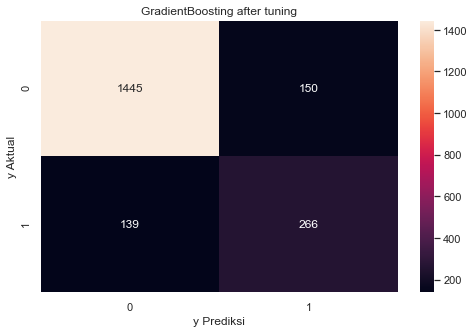

In [52]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_gbc_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('GradientBoosting after tuning');

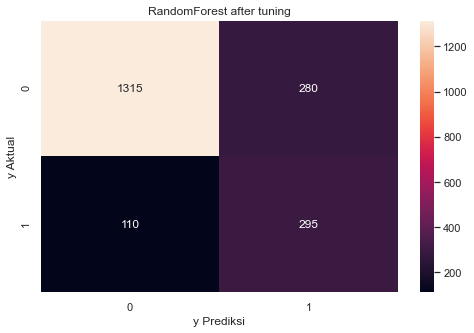

In [53]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('RandomForest after tuning');

## **Summary**

Model paling optimal pada case churn dengan processing yang telah dilakukan adalah Random Forest, dengan nilai recall 73%. Hasil yang didapat antara sebelum dan sesudah tuning berbeda cukup signifikan, di mana proses tuning membantu mengoptimalkan performa model.

Metric recall digunakan karena cost function dari false negative dianggap lebih besar dari false positif, sehingga jumlah false negative yang dihasilkan oleh model harus diminimalisasikan. Namun, karena jumlah kelas 1 nya hanya sekitar 20% dari jumlah data, menggunakan teknik resampling saja belum cukup untuk bisa menghasilkan model dengan performa optimal, harus dicoba dengan melakukan pendekatan lain, misalnya dikombinasikan dengan feature engineering.